In [61]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((-1, 28, 28, 1)) #60000개
test_images = test_images.reshape((-1, 28, 28, 1))

#0~1 사이 값으로 정규화
train_images = train_images / 255.
test_images = test_images / 255.

#loss값 낮아지도록 학습 so 과적합 문제
#valid set: 전체 train의 75% 정도 가져와서 overfitting 일어나는지 확인 & test는 최종 검사용
valid_images, test_images, valid_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.15, shuffle=True)

batch 정규화

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

class ConvBNRelu(Model):
  def __init__(self, filters, kernel_size=3, strides=(1,1), padding='same'):
    # 모델 상속: 부모의 init 함수 호출
    super(ConvBNRelu, self).__init__()
    self.conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
                       padding=padding, kernel_initializer='glorot_normal')
    self.batchnorm = BatchNormalization()

  def call(self, inputs, training=False):
    layer = self.conv(inputs)
    layer = self.batchnorm(layer)
    layer = tf.nn.relu(layer)

    return layer

In [3]:
class DenseBNRelu(Model):
  def __init__(self, units):
    super(DenseBNRelu, self).__init__()
    self.dense = Dense(units=units, kernel_initializer='glorot_normal')
    self.batchnorm = BatchNormalization()

  def call(self, inputs, training=False):
    layer = self.dense(inputs)
    layer = self.batchnorm(layer)
    layer = tf.nn.relu(layer)

    return layer

In [4]:
class MNISTModel(Model):
  def __init__(self):
    super(MNISTModel, self).__init__()
    self.conv1 = ConvBNRelu(filters=32, kernel_size=(3,3), padding='valid')
    self.pool1 = MaxPool2D()
    self.conv2 = ConvBNRelu(filters=64, kernel_size=(3,3), padding='valid')
    self.pool2 = MaxPool2D()
    self.conv3 = ConvBNRelu(filters=32, kernel_size=(3,3), padding='valid')
    self.flat = Flatten()
    self.dense4 = DenseBNRelu(units=64)
    self.drop = Dropout(0.2)
    self.outputs = Dense(10, activation='softmax') # 얘는 softmax 적용해야 하므로 relu 주면 안됨

  # call은 Model에 정의되어 있는 함수이므로 input값 항상 같아야 함
  def call(self, inputs, training=False):
    net = self.conv1(inputs)
    net = self.pool1(net)
    net = self.conv2(net)
    net = self.pool2(net)
    net = self.conv3(net)
    net = self.flat(net)
    net = self.dense4(net)
    net = self.drop(net)
    net = self.outputs(net)

    return net

In [5]:
model = MNISTModel()
model(Input(shape=(28, 28, 1)))
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_bn_relu (ConvBNRelu)   multiple                  448       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv_bn_relu_1 (ConvBNRelu)  multiple                 18752     
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv_bn_relu_2 (ConvBNRelu)  multiple                 18592     
                                                                 
 flatten (Flatten)           multiple                  

In [14]:
#맨 마지막에 나오는 모델은 과적합된 bad model! 
#so, 학습을 진행하면서 모델 save해야 함 -> 앞쪽에 나온 좋은 모델 가져오기 위해!
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_SAVE_FOLDER = '/content/drive/MyDrive/models/'
model_path = f"{MODEL_SAVE_FOLDER}mnist-{{epoch:d}}-{{val_loss:.5f}}-{{val_accuracy:.5f}}.hdf5"

cb_checkpoint = ModelCheckpoint(filepath=model_path,
                                monitor='val_accuracy',
                                verbose=1,
                                save_weights_only=True,
                                save_best_only=True)

cb_early_stopping = EarlyStopping(monitor='val_accuracy', patience=6)

In [15]:
! rm '/content/drive/MyDrive/models/'*

rm: cannot remove '/content/drive/MyDrive/models/*': No such file or directory


In [16]:
learning_rate = 0.001
batch_size = 200

# ExponenitalDecay(지수적 감쇠): lr 처음에는 크게, 갈수록 decay; initial lr,
#+) decay_steps=몇번 스텝 갔을 때 떨어질 것인지, staircase=부드럽게 or 계단식
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, train_images.shape[0]/batch_size*5, 0.5, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_decay)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
hist = model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels),
                 epochs=100, batch_size=batch_size,
                 callbacks=[cb_checkpoint, cb_early_stopping])

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9889
Epoch 1: val_accuracy improved from -inf to 0.98800, saving model to /content/drive/MyDrive/modelsmnist-1-0.03571-0.98800.hdf5
300/300 [==============================] - 6s 16ms/step - loss: 0.0387 - accuracy: 0.9889 - val_loss: 0.0357 - val_accuracy: 0.9880
Epoch 2/100
297/300 [============================>.] - ETA: 0s - loss: 0.0270 - accuracy: 0.9921
Epoch 2: val_accuracy did not improve from 0.98800
300/300 [==============================] - 4s 14ms/step - loss: 0.0270 - accuracy: 0.9920 - val_loss: 0.0560 - val_accuracy: 0.9833
Epoch 3/100
297/300 [============================>.] - ETA: 0s - loss: 0.0209 - accuracy: 0.9938
Epoch 3: val_accuracy improved from 0.98800 to 0.99200, saving model to /content/drive/MyDrive/modelsmnist-3-0.02614-0.99200.hdf5
300/300 [==============================] - 4s 15ms/step - loss: 0.0208 - accuracy: 0.9938 - val_loss: 0.0261 - val_accuracy: 0.9920
Epoch

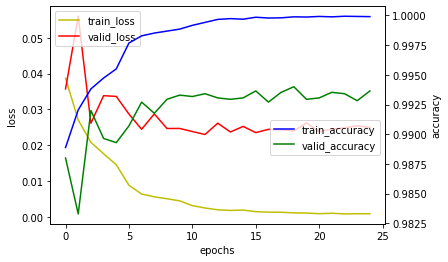

In [18]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='valid_loss')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='valid_accuracy')
acc_ax.set_xlabel('epochs')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right', bbox_to_anchor=(1, 0.5))

plt.show()
#batch normal 활용하면 학습 훨씬 빠르다

VGG : pre-trained model
- 밑바닥 딥러닝 교재 8장 참고

In [62]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
# VGG16: RGB값 가지고 있음

In [63]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape, test_images.shape)

(60000, 28, 28) (10000, 28, 28)


In [64]:
## 3채널로 만들기 위한 작업
#이미지 뻥튀기 하기 위해 (28,28)을 784로 바꾸는 과정
train_images = train_images.reshape(-1, 784).astype('float32') # (60000, 28, 28)을 이렇게 바꿈
test_images = test_images.reshape(-1, 784).astype('float32')

print(train_images.shape, test_images.shape)

(60000, 784) (10000, 784)


In [65]:
## 3 채널로 만들기
#Augmentation: 데이터 뻥튀기 -> VGG 차원 맞추기 위해 이미지 데이터들을 뻥튀기 시키기!
#dstack: train_images 3개를 쌓는 것!
train_images = np.dstack([train_images]*3)
test_images = np.dstack([test_images]*3)

In [66]:
# channel의 개수 3개인 것 확인
train_images.shape, test_images.shape

((60000, 784, 3), (10000, 784, 3))

In [67]:
## 이미지로 변경
#뻥튀기 한 다음에 2D 이미지 형태로 들어가야 하므로 다시 돌려놔야 함
train_images = train_images.reshape(-1, 28, 28, 3)
test_images = test_images.reshape(-1, 28, 28, 3)

In [68]:
train_images.shape, valid_images.shape, test_images.shape

((60000, 28, 28, 3), (8500, 28, 28, 1), (10000, 28, 28, 3))

In [69]:
## 48*48 사이즈로 변경
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

#resize((width, height)) : 포토샵에서 사진 늘리는 것처럼 resolution을 (48,48)로 늘릴 수 있음
#우리가 필요한 건 데이터이므로 PIL 이미지를 img_to_array에 넘겨서 array값 받기 -> list로 넘겼으니까 asarray
train_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48, 48))) for im in train_images])
test_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48, 48))) for im in test_images])

In [70]:
train_images.shape, test_images.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [71]:
train_images = train_images / 255.
test_images = test_images / 255.

In [72]:
valid_images, test_images, valid_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.15, shuffle=True)

In [73]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
vgg_model.summary()
# include_top: 3개의 fully-connected-layer -> 우리는 이거 자르고 우리걸 붙일 것

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [74]:
layer_dict = {layer.name : layer for layer in vgg_model.layers}
layer_dict
#{이름 : 객체}

{'block1_conv1': <keras.layers.convolutional.Conv2D at 0x7f36366787d0>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x7f3636678bd0>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x7f3634df05d0>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x7f363639e810>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x7f3634bdcd90>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x7f363639ee10>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x7f3636724050>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x7f363639e510>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x7f363610ae90>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x7f363638e890>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x7f3636710e50>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x7f3633f22890>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x7f36366979d0>,
 'block4_pool': <keras.layers.pooling.MaxPooling2D at 0x7f363670691

Transfer Learning

In [75]:
# Functional API 방법
#VGG에서 pre-trained된 layer 일부 떼어와서 내 알고리즘에 적용
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

x = layer_dict['block2_conv2'].output

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(10, activation='softmax')(x)

In [76]:
custom_model = Model(inputs=vgg_model.input, outputs=x)
custom_model.summary()
#block2_conv2까지는 VGG에서 가져온 것: weight도
#이후: glorot으로 초기화된 weight 사용

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 64)        7379

In [77]:
for layer in custom_model.layers[:7]:
  layer.trainable = False #weight update 안하겠다

custom_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [78]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_SAVE_FOLDER = '/content/drive/MyDrive/models'
model_path = f"{MODEL_SAVE_FOLDER}mnist-{{epoch:d}}-{{val_loss:.5f}}-{{val_accuracy:.5f}}.hdf5"

cb_checkpoint = ModelCheckpoint(filepath=model_path,
                                monitor='val_accuracy',
                                verbose=1,
                                save_weights_only=True,
                                save_best_only=True)

cb_early_stopping = EarlyStopping(monitor='val_accuracy', patience=6)

In [79]:
hist = custom_model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels),
                        epochs=100, batch_size=200,
                        callbacks=[cb_checkpoint, cb_early_stopping])

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 1.8063 - accuracy: 0.8046
Epoch 1: val_accuracy improved from -inf to 0.96224, saving model to /content/drive/MyDrive/modelsmnist-1-0.14173-0.96224.hdf5
300/300 [==============================] - 21s 69ms/step - loss: 1.8063 - accuracy: 0.8046 - val_loss: 0.1417 - val_accuracy: 0.9622
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.9129
Epoch 2: val_accuracy improved from 0.96224 to 0.97318, saving model to /content/drive/MyDrive/modelsmnist-2-0.10132-0.97318.hdf5
300/300 [==============================] - 20s 68ms/step - loss: 0.2858 - accuracy: 0.9129 - val_loss: 0.1013 - val_accuracy: 0.9732
Epoch 3/100
300/300 [==============================] - ETA: 0s - loss: 0.2221 - accuracy: 0.9334
Epoch 3: val_accuracy improved from 0.97318 to 0.98165, saving model to /content/drive/MyDrive/modelsmnist-3-0.06905-0.98165.hdf5
300/300 [==============================] - 20s 68ms/step

In [83]:
saved_path = '/content/drive/MyDrive/modelsmnist-11-0.05405-0.98729.hdf5'
custom_model.load_weights(saved_path)

custom_model.evaluate(test_images, test_labels)

47/47 [==============================] - 1s 18ms/step - loss: 0.0401 - accuracy: 0.9887


[0.04008500277996063, 0.9886666536331177]